<a href="https://colab.research.google.com/github/Carolyn-Ha/MDST/blob/main/14_2_lec14_getting_started3_regression_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook credit**: based on the F. Chollet's original notebook [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter04_getting-started-with-neural-networks.ipynb).

### ***Note***
- demonstration of K-fold validation
- classification <-> regression(outcome is real valued)

- small number of data points: to make the good use of the very limited number of data points -> going to do K-fold validation

## Predicting house prices: A regression example

We have discussed _regression problems_ before
These consist of predicting a continuous value instead of a discrete label:
- predicting the temperature tomorrow, given meteorological data
- predicting the time that a software project will take to complete, given its specifications

However, we only discussed the linear regression case before where our predictions models were *linear*. Deep learning allows us to buil complex *non-linear* prediction models.

### The Boston Housing Price dataset

- we’ll predict the median price of homes in a given Boston suburb in the mid-1970s
- features of the suburb include things like the crime rate, the local property tax rate, and so on
- it has relatively few data points: only 506, split between 404 training samples and 102 test samples
- each feature in the input data (for example, the crime rate) has a different scale
  - some values are proportions, which take values between 0 and 1
  - others take values between 1 and 12
  - others between 0 and 100, and so on.

**Loading the Boston housing dataset**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
from tensorflow.keras. datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [ ]:
#1) real valued number
train_data

#2) train_data.shape = (404, 13)
  #(1) 404 data points, each with 13 features

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

There is quite a bit of variation in the ranges that the 13 features lie in. The features themselves are described [here](http://lib.stat.cmu.edu/datasets/boston).

In [ ]:
#3) looking at mean, max of every features => for standardization/scaling
tf.reduce_min(train_data, axis=0).numpy()

array([6.3200e-03, 0.0000e+00, 4.6000e-01, 0.0000e+00, 3.8500e-01,
       3.5610e+00, 2.9000e+00, 1.1296e+00, 1.0000e+00, 1.8800e+02,
       1.2600e+01, 3.2000e-01, 1.7300e+00])

In [ ]:
tf.reduce_max(train_data, axis=0).numpy()

array([ 88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,   8.725 ,
       100.    ,  10.7103,  24.    , 711.    ,  22.    , 396.9   ,
        37.97  ])

In [ ]:
#4) looking at test dataset
test_data.shape

(102, 13)

In [ ]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [ ]:
[train_targets.min(), train_targets.max()]
  #(1) found out that price is in the range of $5000~$50,000

[5.0, 50.0]

### Preparing the data

- widespread best practice is to do **feature-wise normalization**
- for each feature in the input data (a column in the input data matrix):
  - subtract the mean of the feature, and
  - divide by the standard deviation
- after this normalization, every feature is centered around 0 and has a unit standard deviation

**Normalizing the data**

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
  #(1) removing the mean across all columns
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
  #(1) even though I calculated the mean only across the train data -> use the same mean to subtract (so that it wouldn't be scaled differently)
    # = doing the exact same transformation across train & test data
test_data /= std

### Building your model

- because few samples are available, we'll use a very small model
- two intermediate layers, each with 64 units
- the less training data you have, the worse overfitting will be
- using a small model is one way to mitigate overfitting

**Model definition**

`"mse"` = mean squared error

`"mae"` = mean absolute error

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1) # final layer is linear
          #don't do softmax, sigmoid: but just output the real value
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation


- to select number of epochs used for training, we could split the data into a training set and a validation set, as we did in the IMDB example
- but we have so few data points
- validation set would end up being very small (e.g., about 100 examples
- validation scores might change a lot depending on which data points we chose for validation and which we chose for training
- the validation scores might have a high variance with regard to the validation split
- would prevent us from reliably evaluating our model.
- best practice in such situations is to use K-fold cross-validation (see figure 4.8)

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/k-fold.png" width="500">

**K-fold validation**

In [ ]:
#four-fold validation

k = 4
num_val_samples = len(train_data) // k
num_epochs = 50 # don't know yet if this is a good choice
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")

      #(1) indexing the same data & targets: so that data and targets are paired
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]

      #(2) everything other than val_data, val_target: would be train data & train_targets
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
        axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
        axis=0
    )
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
        # verbose=0: during training, there will be no output to the console regarding the training progress (silent mode)

      #(3) evaluating based on the validation data that we singled out
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0


In [ ]:
all_scores

In [ ]:
#1) mean of all the scores => aggregating the scores
  #(1) use this score to play with epochs, NN size & depth
np.mean(all_scores)

- different runs do indeed show rather different validation scores
- average validation score is a much more reliable metric than any single score
- how much are we off on average?
- is it significant? (recall that prices range from 5k to 50k)

**Saving the validation logs at each fold**

In [ ]:
num_epochs = 300 # don't know yet if this is a good choice
all_mae_histories = [] # store entire mae history in training as opposed to a single number
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
        axis=0
    )
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["mae"]
    all_mae_histories.append(mae_history)

  # same code: but want to save all mae histories
    #(1) record every history of mean absolute error
    #(2) reason for recording the errors: to give some even more stability
      # - want to look at MAE over the whole procedure as opposed to just one single number

In [ ]:
len(all_mae_histories)

all_mae_histories
  #(1) list of 4 lists: every single list will have the MAE numbers

In [ ]:
#averaging the whole list
  #(1) for the first 9 times steps: going to prince where the average MAE
  #(2) first few average MAE scores will be large
for i in range(9):
    mean  = np.mean([x[i] for x in all_mae_histories])
    print(f"{mean}", end = " ")

20.51292848587036 17.042250156402588 12.831626892089844 8.672714948654175 6.184908628463745 4.947079300880432 4.168828129768372 3.6908249258995056 3.4063934683799744 

**Building the history of successive mean K-fold validation scores**

In [ ]:
#for each epoch: calculate the whole history

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories])
    for i in range(num_epochs)
]

**Plotting validation scores**

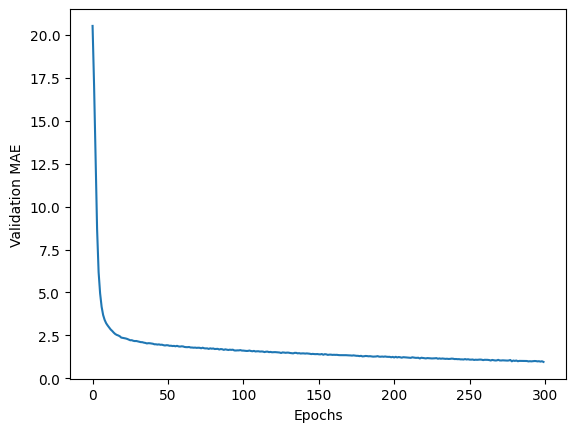

In [ ]:
plt.plot(range(len(average_mae_history)), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

- as we saw earlier, the first 10 data points have high validation MAE
- makes it a little difficult to read the plot
- let's replot after omitting the first 10 points

**Plotting validation scores, excluding the first 10 data points**

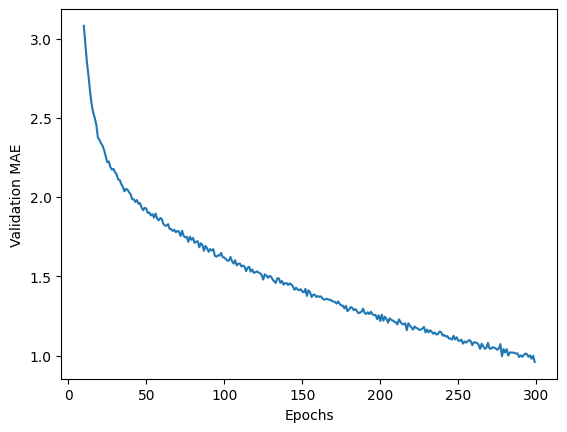

In [ ]:
#truncated(잘린) => truncated_mae_history: 앞 10개(mae가 클 것이기 때문에) 제외한 mae history
truncated_mae_history = average_mae_history[10:]
plt.plot(range(10, len(average_mae_history)), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

- validation MAE stops improving significantly after 120–140 epochs
- past that point, we start *overfitting*


**Training the final model**

- Here we only tuned number of epochs
- you could also adjust the size of the intermediate layers
- once you're finished tuning, you can train a final production model
- this will use _all_ of the training data
- it will use the best choices for tuning parameters (e.g., 130 for epochs in our case)
- you will evaluate its performance on the test data (that we haven't touched at all so far)

In [ ]:
#variation:
  #(1) change number of epochs(epoch = one complete pass through the entire training dataset during the training of a NN)
  #(2) change the intermediate layers(NN architecture)
    #=> do the same process with different number of epochs: figure out which combination of hyperparameters will give you the lowest validation MAE
    #=> after finding the best hyperparameter: use that to build the final model -> evaluate on the test dataset(train with the whole dataset & test it on the test dataset)


#1) no longer using partial training data => but use the whole datas
model = build_model()
model.fit(train_data, train_targets,
          epochs = 130, batch_size=16, verbose=0)

#2) testing on the test set that we have not touched before
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 15.8273 - mae: 2.5961


In [ ]:
test_mae_score

#test_mae > validation_mae: since test dataset is the dataset that you have never seen before
#test_mse > validation_mse: mse(mean squared error)

2.5960752964019775

### Generating predictions on new data

In [ ]:
predictions = model.predict(test_data)
predictions[10] # prediction for the 10th house in test set

4/4 [==============================] - 0s 3ms/step


array([18.374851], dtype=float32)